# Multiple Linear Regression
Here we use the Linear Regression method on the converted data from the descriptive_analysis.ipynb.

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta
from scipy import stats
np.random.seed(1)

In [92]:
# Read in data, set index to column 0, parse dates and display first 5 rows
test = pd.read_csv('./data/converted_test_2020_07_17_12-15-40.csv', index_col=0)
train = pd.read_csv('./data/converted_train_2020_07_17_12-15-40.csv', index_col=0)
train.head(5)

,Request_Date,Flight_Date,Duration_Time,Departure_hour,flight_unique_id,route_abb,flight_number,Price,Currency,min_future_price,...,min_future_price_in_eur,Request_Weekday,Request_timeofday,Departure_timeofday,flight_distance_km,Request_hour,Request_Date_Month,Flight_Date_Month,route_abb_from,route_abb_to
0,2019-06-03 11:00:00,2019-06-05 19:00:00,56.0,19,2019-06-05 FR 146,SXF-STN,FR 146,208.07,€,259.07,...,259.070000,Monday,Morning,Evening,907.2,11,6,6,SXF,STN
1,2019-06-03 23:00:00,2019-06-05 19:00:00,44.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Monday,Night,Evening,907.2,23,6,6,SXF,STN
2,2019-06-04 11:00:00,2019-06-05 19:00:00,32.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Tuesday,Morning,Evening,907.2,11,6,6,SXF,STN
3,2019-06-04 23:00:00,2019-06-05 19:00:00,20.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Tuesday,Night,Evening,907.2,23,6,6,SXF,STN
4,2019-06-03 11:00:00,2019-06-05 21:00:00,58.0,21,2019-06-05 FR 147,STN-SXF,FR 147,127.49,£,223.37,...,252.059401,Monday,Morning,Night,907.2,11,6,6,STN,SXF


In [93]:
# Check for nulls
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


# Date preperation

We will now do some minor modifications to put our data into machine-understandable terms. We will use the Python library Pandas for the data manipulation relying on the structure known as dataframe.

The first step is the one-hot-encoding of the data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.

In [94]:
# One Hot encoding for categorical values / Drop first category is a must for linear regression
train = pd.get_dummies(train, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to'], drop_first=True)
test = pd.get_dummies(test, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to'], drop_first=True)

In [95]:
# Add train column
test['train'] = 0
train['train'] = 1

# Equal columns across both tables
combined = pd.concat([train,test], sort=False)
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]

# Fill NaN with 0
train = train.fillna(0)
test = test.fillna(0)

# Drop train column
test.drop(['train'], axis=1, inplace=True)
train.drop(['train'], axis=1, inplace=True)

In [96]:
# Drop columns we do not need from train
train_dropped = train.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

# Drop columns we do not need from test
test_dropped = test.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'min_future_price', 'min_future_price_in_eur', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

In the next step we separate the data into the features and target. The target, also known as the label, is the value we want to predict, in this case the min_future_price and the features are all the columns the model uses to make a prediction.

In [97]:
# Generate test and target
X = train_dropped.drop(columns=['min_future_price_in_eur'])
y = train_dropped['min_future_price_in_eur'].values

# Checking for Linearity

Before executing a linear regression model, we check if a linear relationship between the dependent variable (min_future_price_eur) and the independent variables exists.

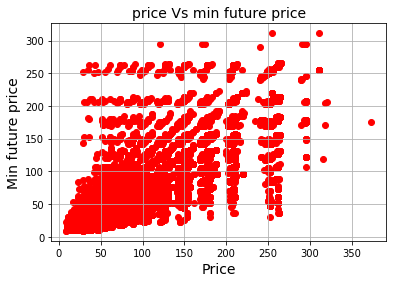

In [98]:
df_lin = pd.DataFrame(train)
 
plt.scatter(df_lin['price_in_eur'], df_lin['min_future_price_in_eur'], color='red')
plt.title('price Vs min future price', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

We can see that a linear relationship between the price and the min_future_price exists. Specifically, when the price goes up the min_future_price also goes up.

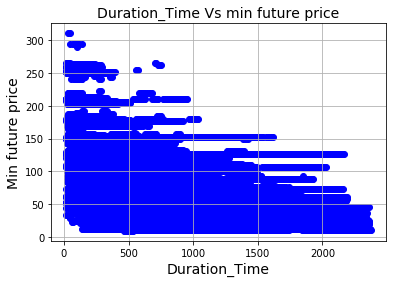

In [99]:
plt.scatter(df_lin['Duration_Time'], df_lin['min_future_price_in_eur'], color='blue')
plt.title('Duration_Time Vs min future price', fontsize=14)
plt.xlabel('Duration_Time', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

We can see that a linear relationship between the price and the min_future_price exists. Specifically, when the Duration_Time goes up the min_future_price decreases.

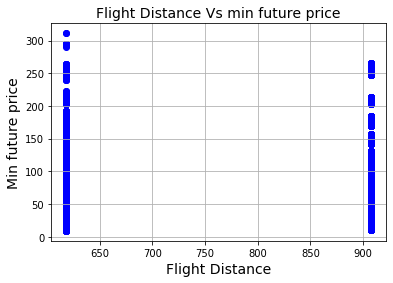

In [100]:
plt.scatter(df_lin['flight_distance_km'], df_lin['min_future_price_in_eur'], color='blue')
plt.title('Flight Distance Vs min future price', fontsize=14)
plt.xlabel('Flight Distance', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

There might be a linear relationship between flight distance and min_future_price. But we do not have enough data.

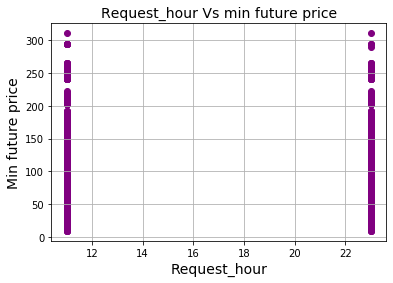

In [101]:
plt.scatter(df_lin['Request_hour'], df_lin['min_future_price_in_eur'], color='purple')
plt.title('Request_hour Vs min future price', fontsize=14)
plt.xlabel('Request_hour', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

There is no linear relationship between request hour and min_future_price

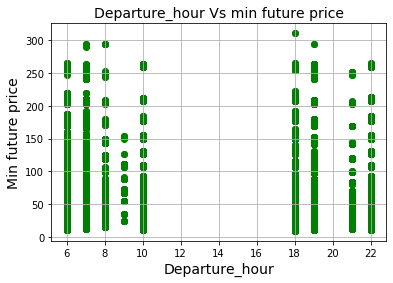

In [102]:
plt.scatter(df_lin['Departure_hour'], df_lin['min_future_price_in_eur'], color='green')
plt.title('Departure_hour Vs min future price', fontsize=14)
plt.xlabel('Departure_hour', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

There is no linear relationship between departure hour and min_future_price

In [103]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
print(stats.pointbiserialr(df_lin['route_abb_from_STN'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['route_abb_from_SXF'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['route_abb_to_STN'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['route_abb_to_SXF'], df_lin['min_future_price_in_eur']))

PointbiserialrResult(correlation=0.03774832787654503, pvalue=9.278150708744862e-28)
PointbiserialrResult(correlation=0.024635823438126522, pvalue=1.0399265762323386e-12)
PointbiserialrResult(correlation=-0.037748327876544946, pvalue=9.278150708744796e-28)
PointbiserialrResult(correlation=0.07165823092252897, pvalue=1.2684529770642404e-95)


There is no significant relationship between route_abb and min_future_price

In [104]:
print(stats.pointbiserialr(df_lin['Request_Weekday_Monday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Tuesday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Wednesday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Thursday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Saturday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Sunday'], df_lin['min_future_price_in_eur']))

PointbiserialrResult(correlation=-0.012981524453102182, pvalue=0.00017398261320498108)
PointbiserialrResult(correlation=-0.005942139934911539, pvalue=0.08573708001252217)
PointbiserialrResult(correlation=0.0021226459945999495, pvalue=0.5393380141945227)
PointbiserialrResult(correlation=0.008940666499375787, pvalue=0.009724961249840527)
PointbiserialrResult(correlation=0.0003838042237119764, pvalue=0.9116273383345177)
PointbiserialrResult(correlation=-0.0075970694003589575, pvalue=0.028027210061278195)


There is no significant relationship between the request weekday and min_future_price

# Feature importance

LassoCV to evaluate the most valuable features. From the above analysis only price_in_eur and Duration_Time can be used

In [105]:
# Features with the highest absolute coef_ value are considered the most important
feature_names = X.columns
clf = LassoCV(cv=6).fit(X, y)
print(clf.score(X, y))
importance = np.abs(clf.coef_)
print(importance)

0.8147735529536608
[0.0120268  0.         0.68649916 0.00298859 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [106]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

Selected features: ['price_in_eur' 'Duration_Time']


LassoCV shows that the features with the highest absolute coef_ value are price_in_eur and Duration_Time. Good!

In [107]:
features = name_features
# Only use relevant features for model
X = X[features]

# Scale Features

We find that the features of the data we used are not at the same scale/units. Duration_Time and price_in_eur are on two differenct scales (hour and km). Regression algorithms can benefit from scaling.

In [108]:
# Scale train and test data
scaler = preprocessing.RobustScaler()
features_log = [[ 'Duration_Time', 'price_in_eur']]
for feature in features_log:
    X[feature] = scaler.fit_transform(train[feature])
    test_dropped[feature] = scaler.fit_transform(test_dropped[feature])

y = scaler.fit_transform(pd.DataFrame(y)).flatten()

# Build model

During training, we let the model ‘see’ the answers, in this case the min_future_price_in_eur, so it can learn how to predict the price from the features. 
We split 80% of the data to the training set and 20% to the testing set. We set the random state to  1 which means the results will be the same each time I run the split for reproducible results.

In [109]:
# Split dataset into train and test data (might want to try random_state=0 to randomize each calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [110]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66899, 2), (66899,), (16725, 2), (16725,))

In [111]:
from sklearn.linear_model import LinearRegression

# Use linear regression model to predict min_future_price
lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [112]:
# A look at the predicted values vs. the actual values
actual = scaler.inverse_transform(pd.DataFrame(y_test))
prediction = scaler.inverse_transform(pd.DataFrame(y_pred))
df_pred = pd.DataFrame({'Actual': actual.flatten(), 'Predicted': prediction.flatten()})
df_pred

,Actual,Predicted
0,58.130000,71.878158
1,177.470000,196.404779
2,20.061109,16.834031
3,205.886665,160.171686
4,52.583689,67.739432
...,...,...
16720,19.990000,14.775055
16721,148.472437,132.419271
16722,23.650000,15.055347
16723,43.340000,30.884993


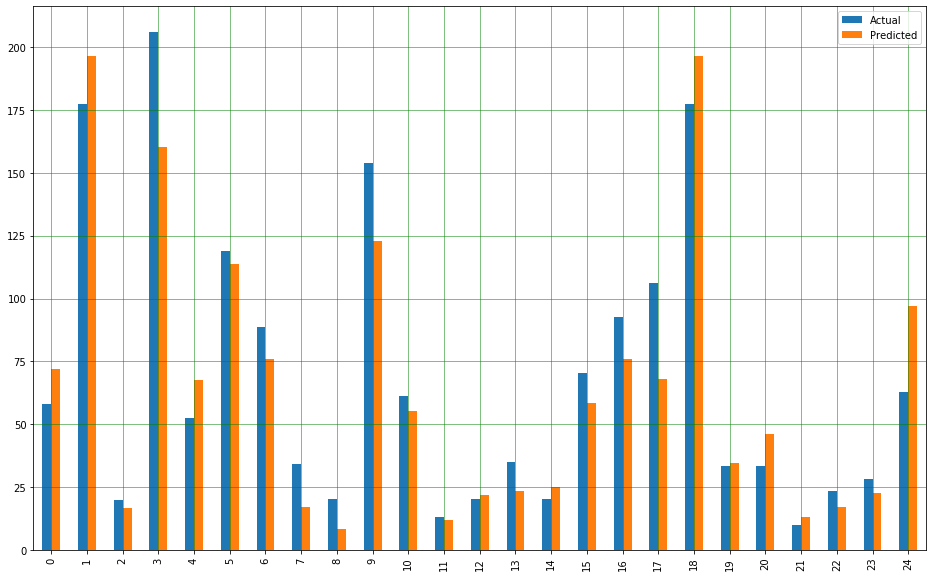

In [113]:
df_pred.head(25).plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Model Evaluation Metrics for Regression

We evaluate the performance of the algorithm. For regression algorithms, three evaluation metrics are commonly used. Mean Absolute Error (MAE), Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE). For these metrics we are using the test data. 

In [114]:
# Return the mean accuracy on the given test data and labels
print('Score:', lin_reg.score(X_test, y_test))

# Return the mean accuracy on the given test data and labels with cross validation 
scores = cross_val_score(lin_model, X, y, cv=6)
print('Cross-validated scores:', scores)

Score: 0.810022511871145
Cross-validated scores: [0.74259783 0.78854976 0.81053998 0.78538463 0.76289933 0.77070407]


With our model we have a mean accuracy of 81.0%. With Cross Validation we have a worse result where 74% is the highest. 

In [115]:
# Calculate the absolute errors
actual = scaler.inverse_transform(pd.DataFrame(y_test))
prediction = scaler.inverse_transform(pd.DataFrame(y_pred))
errors = abs(prediction - actual)

# Print out the mean absolute error (MAE)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Print out the mean squared error (MSE)
print('Mean Squared Error:', round(np.square(errors).mean(), 2))  

# Print out the root mean squared error (RMSE)
# Lower values of RMSE indicate better fit
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(actual, prediction)), 2))

Mean Absolute Error: 12.66
Mean Squared Error: 407.59
Root Mean Squared Error: 20.19


# Use on Test Data

Finally we can use the linear regression model on our test data which does not contain min_future_price

In [123]:
test_pred = lin_reg.predict(test_dropped[features])

# Reverse the scaling to reveal actual values
test_pred_inverse = scaler.inverse_transform(pd.DataFrame(test_pred))
test_price_in_eur = scaler.inverse_transform(np.array(test_dropped[['price_in_eur']]))

In [124]:
final_pred = pd.DataFrame({'Request_Date': test['Request_Date'], 'flight_unique_id': test['flight_unique_id'], 'price_in_eur': test_price_in_eur.flatten(), 'min_future_price_eur': test_pred_inverse.flatten()})
final_pred

,Request_Date,flight_unique_id,price_in_eur,min_future_price_eur
0,2019-06-03 11:00:00,2019-07-02 FR 145,15.203531,21.958094
1,2019-06-03 23:00:00,2019-07-02 FR 145,24.053392,29.292055
2,2019-06-04 11:00:00,2019-07-02 FR 145,24.015883,29.484114
3,2019-06-04 23:00:00,2019-07-02 FR 145,24.015883,29.706315
4,2019-06-05 11:00:00,2019-07-02 FR 145,24.049324,29.955390
...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 FR 8545,22.995549,39.718683
5579,2019-07-31 11:00:00,2019-08-02 FR 8545,28.078581,44.025616
5580,2019-07-31 23:00:00,2019-08-02 FR 8545,28.078581,44.247817
5581,2019-08-01 11:00:00,2019-08-02 FR 8545,28.078581,44.470018


# Compute Buy False/True

Binary encoding of buy or wait for the price to drop. If min_future_price > price = buy (1) | min_future_price < price = wait (0)

In [121]:
final_pred['buy'] = np.nan
for index, row in final_pred.iterrows():
    if row.price_in_eur > row.min_future_price_eur:
        final_pred.set_value(index,'buy',0)
    else:
        final_pred.set_value(index,'buy',1)
print(final_pred)
final_pred.to_csv('./data/linear_regression_test.csv', sep=',')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


            Request_Date    flight_unique_id  price_in_eur  \
0    2019-06-03 11:00:00   2019-07-02 FR 145     15.203531   
1    2019-06-03 23:00:00   2019-07-02 FR 145     24.053392   
2    2019-06-04 11:00:00   2019-07-02 FR 145     24.015883   
3    2019-06-04 23:00:00   2019-07-02 FR 145     24.015883   
4    2019-06-05 11:00:00   2019-07-02 FR 145     24.049324   
...                  ...                 ...           ...   
5578 2019-07-30 23:00:00  2019-08-02 FR 8545     22.995549   
5579 2019-07-31 11:00:00  2019-08-02 FR 8545     28.078581   
5580 2019-07-31 23:00:00  2019-08-02 FR 8545     28.078581   
5581 2019-08-01 11:00:00  2019-08-02 FR 8545     28.078581   
5582 2019-08-01 23:00:00  2019-08-02 FR 8545     28.078581   

      min_future_price_eur  buy  
0                21.958094  1.0  
1                29.292055  1.0  
2                29.484114  1.0  
3                29.706315  1.0  
4                29.955390  1.0  
...                    ...  ...  
5578             

# Optimization Performance
From moodle page:
Das Vorhersagemodell für die Entscheidung Warten oder Kaufen eines Flugtickets soll hinsichtlich der Vorhersagegenauigkeit optimiert werden, d.h. 
Genauigkeit = Anzahl der richtigen Entscheidungen / Anzahl aller Entscheidungen. 

In [119]:
optimize_final_pred = final_pred
def getModelScore(data):
    data['Request_Date'] = pd.to_datetime(data['Request_Date'], format='%Y-%m-%d %H:%M:%S')
    decision_true_total = 0
    unique_flights_id = data['flight_unique_id'].unique()
    for element in unique_flights_id:
        flights = data[data['flight_unique_id'] == element].sort_values('Request_Date', ascending=False)
        for index, flight in flights.iterrows():
            filtered_flights = flights[flights['Request_Date'] >= flight.Request_Date].sort_values('Request_Date', ascending=False)
            if flight.buy == 1:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] < flight.price_in_eur]
            if flight.buy == 0:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] > flight.price_in_eur]
            if len(filtered_flights) == 0:
                decision_true_total = decision_true_total + 1
    print('True: ' + str(decision_true_total))
    print('Total: ' + str(len(data)))
    return decision_true_total/len(data)

getModelScore(optimize_final_pred)
# Standard Scaler = 1264 ['price_in_eur' 'Duration_Time']
# Robust Scaler = 1280
# MinMaxScaler = 742
# PowerTransformer = 1257

True: 1280
Total: 5583


0.2292674189503851

Only 1280 of 5583 decisions were correct. Eventhough the linear regression model score was above 80% the real world application shows that only approx. 23% of all predicitons are correct. This means that more than every fith person using our service will get a bad or false prediciton. Consequently we would loose customers.

Outlook:
In this notebook linear regression was depicted. Luckily there are many other ways for us to improve upon our results. We could try to use clustering or classification instead for example. Furthermore bagging, or boosting could be applied. The most promising would be to use a stacking regressor which uses xgbm, svm, lightgbm in conjuction. This however would require a lot of tweaking and optimization for each model.

# Tools

In [120]:
# Get the next best price from the test data set.
check_final_pred = final_pred
def checkDateToBuy(data, flight_unique_id, request_date):
    flights = data[data['flight_unique_id'] == flight_unique_id].sort_values('Request_Date', ascending=False)
    price_saving = 0
    if request_date <= flights.iloc[0].Request_Date:
        flights['Request_Date'] = pd.to_datetime(flights['Request_Date'], format='%Y-%m-%d %H:%M:%S')
        flights = flights[flights['Request_Date'] > request_date].sort_values('Request_Date', ascending=True)
        initialPrice = 0
        flights = flights.reset_index()
        for index, flight in flights.iterrows():
            if index == 0:
                initialPrice = flight.price_in_eur
            if flight.buy == 1:
                price_saving = initialPrice - flight.price_in_eur
                return [request_date, price_saving, flight.Request_Date]
        return 0
    else:
        print('No data available for the supplied Request_Date')

checkDateToBuy(check_final_pred, '2019-07-02 FR 145', datetime(2019, 5, 1))

[datetime.datetime(2019, 5, 1, 0, 0), 0.0, Timestamp('2019-06-03 11:00:00')]